In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True      
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    cell_files = np.array(data['filenames'])
    cell_targets = np_utils.to_categorical(np.array(data['target']), 4)
    return cell_files, cell_targets

In [3]:

# load train, test, and validation datasets
train_files, train_targets = load_dataset('datasets/TRAIN')
test_files, test_targets = load_dataset('datasets/TEST')

In [4]:
#split training sets into validation and training set 
train_files, validation_files, train_targets, validation_targets = train_test_split(train_files, train_targets, test_size = 0.33, random_state=42)



In [5]:
# print statistics about the dataset
print('There are %s total white blood cell images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training white blood cell images.' % len(train_files))
print('There are %d validation white blood cell images.'% len(validation_files))
print('There are %d test white blood cell images.'% len(test_files))

There are 3340 total white blood cell images.

There are 1340 training white blood cell images.
There are 660 validation white blood cell images.
There are 2000 test white blood cell images.


In [6]:
#preprocess
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = (path_to_tensor(img_path) 
    for img_path in tqdm(img_paths))
    return np.vstack(list_of_tensors)
print('image preprocessed with keras') 

image preprocessed with keras


In [7]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255
valid_tensors = paths_to_tensor(validation_files).astype('float32')/255

  0%|          | 0/1340 [00:00<?, ?it/s]/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]
100%|██████████| 660/660 [00:00<00:00, 874.29it/s]


In [8]:
print('Train Images Shape: {} size: {:,}'.format(train_tensors.shape, train_tensors.size))
print('Validation Images Shape: {} size: {:,}'.format(valid_tensors.shape, valid_tensors.size))
print('Test Images Shape: {} size: {:,}'.format(test_tensors.shape, test_tensors.size))

Train Images Shape: (1340, 224, 224, 3) size: 201,707,520
Validation Images Shape: (660, 224, 224, 3) size: 99,348,480
Test Images Shape: (2000, 224, 224, 3) size: 301,056,000


In [9]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

In [10]:
#Extract Xception features and weights 
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
train_xception = xception_bottleneck.predict(train_tensors, batch_size = 50, verbose = 1)
valid_xception = xception_bottleneck.predict(valid_tensors, batch_size = 50, verbose = 1)
test_xception = xception_bottleneck.predict(test_tensors, batch_size = 50, verbose = 1)


Instructions for updating:
Colocations handled automatically by placer.
2000/2000 [==============================] - 663s 331ms/step


In [11]:
print('Train Images Shape: {} size: {:,}'.format(train_xception.shape, train_xception.size))
print('Validation Images Shape: {} size: {:,}'.format(valid_xception.shape, valid_xception.size))
print('Test Images Shape: {} size: {:,}'.format(test_xception.shape, test_xception.size))

Train Images Shape: (1340, 7, 7, 2048) size: 134,471,680
Validation Images Shape: (660, 7, 7, 2048) size: 66,232,320
Test Images Shape: (2000, 7, 7, 2048) size: 200,704,000


In [12]:
input_shape = train_xception.shape[1:]
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', activation='relu', input_shape = train_xception.shape[1:]))
model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
model.add(Dense(4, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 7, 7, 32)          589856    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 589,988
Trainable params: 589,988
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [14]:
#Train the model
xception_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.test.hdf5', verbose=1, save_best_only=True)
epochs =30
batch_size = 50
xception_history = model.fit(train_xception, train_targets, validation_data = (valid_xception, validation_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[xception_checkpointer], verbose=1)
  

Instructions for updating:
Use tf.cast instead.
Train on 1340 samples, validate on 660 samples
Epoch 1/30
1340/1340 [==============================] - 11s 8ms/step - loss: 2.1930 - acc: 0.2948 - val_loss: 1.2969 - val_acc: 0.3439

Epoch 00001: val_loss improved from inf to 1.29687, saving model to saved_models/weights.best.test.hdf5
Epoch 2/30
1340/1340 [==============================] - 3s 2ms/step - loss: 1.2666 - acc: 0.3933 - val_loss: 1.1552 - val_acc: 0.5136

Epoch 00002: val_loss improved from 1.29687 to 1.15522, saving model to saved_models/weights.best.test.hdf5
Epoch 3/30
1340/1340 [==============================] - 3s 2ms/step - loss: 1.1838 - acc: 0.4813 - val_loss: 1.1103 - val_acc: 0.5182

Epoch 00003: val_loss improved from 1.15522 to 1.11029, saving model to saved_models/weights.best.test.hdf5
Epoch 4/30
1340/1340 [==============================] - 4s 3ms/step - loss: 1.0891 - acc: 0.5425 - val_loss: 1.1466 - val_acc: 0.4970

Epoch 00004: val_loss did not improve from 1

In [15]:
# Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.test.hdf5')
   

In [21]:
#Test the model
xception_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]




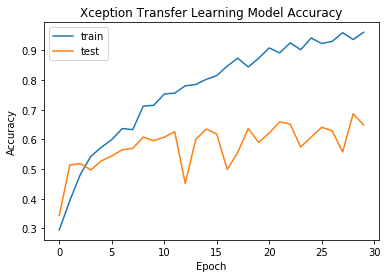

In [17]:
# Visualize Xception Accuracy Score 
plt.plot(xception_history.history['acc'])
plt.plot(xception_history.history['val_acc'])
plt.title('Xception Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


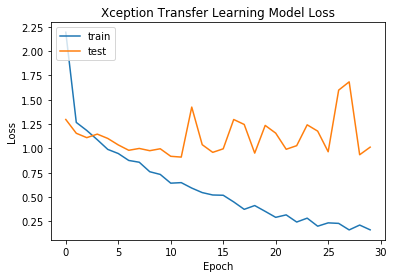

In [18]:
#Visualize Xception Model Loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('Xception Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [22]:
#Test the model
xception_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in train_xception]

#test accuracy
train_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(train_targets, axis=1))/len(xception_predictions)
print('Train accuracy: %.4f%%' % train_accuracy)

Train accuracy: 82.7612%
